Notes on version:

*  With ChemPy
*  Closed system - CO2g drops throughout reaction
*  [CO2(aq)] maintained in line with solubility and mass transfer
*  [H2CO3] production governed by ChemPy
*  [H2CO3] removal governed by K_carb constand and H2CO3 concentration for conversion from H2CO3 -> CaCO3)
*   Assumes constant pressure of 1 atm
*   Output as time to reach set target mass of captured CO2 as a % of concrete (mass for mass)
*   Output of flow rate CO2 to maintain steady state

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure ChemPy is installed
try:
    import chempy
except ModuleNotFoundError:
    !pip install chempy
    import chempy

from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction
from chempy import ReactionSystem
from chempy.chemistry import Reaction, Substance

# Constants
R = 8.314  # Universal gas constant, J/(mol·K)
print(f"R: {R} J/(mol·K)")
T = 298.15  # Temperature in Kelvin (25°C)
print(f"T: {T} K")
H_atm = 29.4  # Henry's Law constant for CO2 in water at 25°C, atm·m³/mol
print(f"H_atm: {H_atm} atm·m³/mol")
H_Pa = H_atm * 101325  # Henry's Law constant in Pa·m³/mol
print(f"H_Pa: {H_Pa} Pa·m³/mol")
k = 1e-6  # Mass transfer coefficient, m/s
print(f"k: {k} m/s")
hydration_level = 0.1  # 10%
print(f"hydration_level: {hydration_level}")
rho_concrete = 2400  # Density of concrete, kg/m³
print(f"rho_concrete: {rho_concrete} kg/m³")
rho_water = 1000  # Density of water, kg/m³
print(f"rho_water: {rho_water} kg/m³")
wetting_coefficient = 0.8  # Wetting coefficient
print(f"wetting_coefficient: {wetting_coefficient}")
P_total_atm = 1.0  # Total pressure in atm (standard pressure)
P_total_Pa = P_total_atm * 101325  # Total pressure in Pa (standard pressure)
print(f"P_total_atm: {P_total_atm} atm")
print(f"P_total_Pa: {P_total_Pa} Pa")
percentage_CO2 = 0.04  # Percentage of CO2 in air (4%)
print(f"percentage_CO2: {percentage_CO2}")
V = 100.0  # Reactor volume in m³
print(f"V: {V} m³")
K_carb = 0.001  # Define K_carb appropriately
print(f"K_carb: {K_carb} ")

# Rate constants for the reaction CO2 + H2O <-> H2CO3
k_forward = 0.039  # Forward rate constant (1/s)
k_reverse = 23  # Reverse rate constant (1/s)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.7/184.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
  Created wheel for chempy: filename=chempy-0.9.0-py2.py3-none-any.whl size=210809 sha256=af7cfbc930fdeacea04c2eaee19ffdcf98a96e0d18a9b5622b3fcaefc9f50bb3
  Stored in directory: /root/.cache/pip/wheels/67/6a/c8/0b931e3c1c6c4e620af52ab72afb8377af84307fc715d3d72b
  Created wheel for pyneqsys: filename=pyneqsys-0.5.7-py2.py3-none-any.whl size=27263 sha256=c8759da5ce577fadcbc4e02cca6d29fcc719757f872f15c199ff5301ed1d505e
  Stored 

In [2]:
# Function to calculate total surface area
def calculate_surface_area_normal_distribution(mean_diameter, std_deviation, min_diameter, max_diameter, reactor_volume, void_fraction, num_samples=100000):
    diameters = np.random.normal(loc=mean_diameter, scale=std_deviation, size=num_samples)
    diameters = diameters[(diameters >= min_diameter) & (diameters <= max_diameter)]
    radii = diameters / 2
    volumes = (4/3) * np.pi * (radii ** 3)
    total_particle_volume = reactor_volume * (1 - void_fraction)
    total_volume_of_sampled_particles = np.sum(volumes)
    scaling_factor = total_particle_volume / total_volume_of_sampled_particles
    surface_areas = 4 * np.pi * (radii ** 2)
    total_surface_area = np.sum(surface_areas * scaling_factor)
    return total_surface_area

# Example usage:
mean_diameter = 0.01  # Mean diameter of 1 cm in meters
print(f"mean_diameter: {mean_diameter} m")
std_deviation = 0.002  # Standard deviation of 0.2 cm in meters
print(f"std_deviation: {std_deviation} m")
min_diameter = 0.005  # Minimum diameter of 0.5 cm in meters
print(f"min_diameter: {min_diameter} m")
max_diameter = 0.015  # Maximum diameter of 1.5 cm in meters
print(f"max_diameter: {max_diameter} m")
reactor_volume = V  # meter
print(f"reactor_volume: {reactor_volume} m³")
void_fraction = 0.4  # 40% void fraction
print(f"void_fraction: {void_fraction}")

total_surface_area = calculate_surface_area_normal_distribution(
    mean_diameter, std_deviation, min_diameter, max_diameter, reactor_volume, void_fraction
)

# Total surface area
print("total_surface_area:", f"{total_surface_area:.4g}", "m²")

# Available surface area for gas exchange
available_surface_area = total_surface_area * wetting_coefficient
print("available_surface_area:", f"{available_surface_area:.4g}", "m²")

mean_diameter: 0.01 m
std_deviation: 0.002 m
min_diameter: 0.005 m
max_diameter: 0.015 m
reactor_volume: 100.0 m³
void_fraction: 0.4
total_surface_area: 3.362e+04 m²
available_surface_area: 2.689e+04 m²


In [3]:
# Total reactor volume
print(f"reactor_volume: {reactor_volume} m³")
void_fraction = 0.4  # 40% void fraction
print(f"void_fraction: {void_fraction} m³")

# Solid phase volume and mass
solid_volume = reactor_volume * (1 - void_fraction)
solid_mass = solid_volume * rho_concrete
print("solid_volume:", f"{solid_volume:.4g}", "m³")
print("solid_mass:", f"{solid_mass:.4g}", "kg")

# Liquid phase mass and volume
liquid_mass = hydration_level * solid_mass
liquid_volume = liquid_mass / rho_water
print("liquid_volume:", f"{liquid_volume:.4g}", "m³")
print("liquid_mass:", f"{liquid_mass:.4g}", "kg")

# Gas phase volume
gas_volume = reactor_volume - solid_volume - liquid_volume
print("gas_volume:", f"{gas_volume:.4g}", "m³")

# Calculate the partial pressure of CO2 in gas phase
P_CO2 = percentage_CO2 * P_total_Pa
print(f"P_CO2: {P_CO2:.4g} Pa")

# Convert partial pressure to concentration in mol/m³
n_CO2 = P_CO2 / (R * T) * gas_volume
concentration_CO2 = n_CO2 / gas_volume
print("n_CO2:", f"{n_CO2:.4g}", "mol")
print("concentration_CO2:", f"{concentration_CO2:.4g}", "mol/m³")


# Initial partial pressure of CO2 in the gas phase
P_CO2_initial = concentration_CO2 * R * T
print("P_CO2_initial:", f"{P_CO2_initial:.4g}", "Pa")


# Initial equilibrium concentration of CO2 in the liquid phase using Henry's Law and standard CO2 concentration in air
C_l_initial_eq = ((P_total_Pa * 0.0004) / H_Pa)*1000
print("C_l_initial_eq (eq in air):", f"{C_l_initial_eq:.4g}", "mol/m³")
#print(f"P_CO2: {(P_total_Pa * 0.0004):.4g} Pa")


# CO2 solubility
C_sol_initial = (P_CO2 / H_Pa)*1000
print("C_sol_initial:", f"{C_sol_initial:.4g}", "mol/m³")

# Initial concentration of CO2 in the gas phase
C_g_initial = P_CO2_initial / (R * T)
print("C_g_initial:", f"{C_g_initial:.4g}", "mol/m³")

# Initial concentration of carbonic acid
H2CO3_initial = 0.0  # Initial concentration of H2CO3 in liquid phase (mol/m³)
print("H2CO3_initial:", f"{H2CO3_initial:.4g}", "mol/m³")

# Lists to store results
time_points = [0]  # Initial time
C_g_values = [C_g_initial]  # Initial gas phase CO2 concentration
C_l_values = [C_l_initial_eq]  # Initial liquid phase CO2 concentration
C_sol_values = [C_sol_initial]  # CO2 solubiliy
mass_transfer_rates = []  # Mass transfer rates
CO2_transferred = []  # CO2 transferred from gas to liquid phase
H2CO3_values = [H2CO3_initial]  # Initial carbonic acid concentration
cumulative_moles_removed = 0
cumulative_removal_values = [0]


# Initial total moles of carbon in the system
initial_moles_CO2_gas = C_g_values[0] * gas_volume
initial_moles_CO2_liquid = C_l_values[0] * liquid_volume
initial_moles_H2CO3 = H2CO3_values[0] * liquid_volume
initial_total_moles_carbon = initial_moles_CO2_gas + initial_moles_CO2_liquid + initial_moles_H2CO3
total_moles_carbon_values = [initial_total_moles_carbon]

print(f"Initial moles CO2 (gas): {initial_moles_CO2_gas:.6f} mol")
print(f"Initial moles CO2 (liquid): {initial_moles_CO2_liquid:.6f} mol")
print(f"Initial moles H2CO3: {initial_moles_H2CO3:.6f} mol")
print(f"Initial total moles of carbon: {initial_total_moles_carbon:.6f} mol")

reactor_volume: 100.0 m³
void_fraction: 0.4 m³
solid_volume: 60 m³
solid_mass: 1.44e+05 kg
liquid_volume: 14.4 m³
liquid_mass: 1.44e+04 kg
gas_volume: 25.6 m³
P_CO2: 4053 Pa
n_CO2: 41.86 mol
concentration_CO2: 1.635 mol/m³
P_CO2_initial: 4053 Pa
C_l_initial_eq (eq in air): 0.01361 mol/m³
C_sol_initial: 1.361 mol/m³
C_g_initial: 1.635 mol/m³
H2CO3_initial: 0 mol/m³
Initial moles CO2 (gas): 41.857351 mol
Initial moles CO2 (liquid): 0.195918 mol
Initial moles H2CO3: 0.000000 mol
Initial total moles of carbon: 42.053269 mol


In [4]:
# Define the reaction system
substances = {
    'CO2(aq)': Substance('CO2(aq)'),
    'H2O': Substance('H2O'),
    'H2CO3(aq)': Substance('H2CO3(aq)')
}

reactions = [
    Reaction({'CO2(aq)': 1, 'H2O': 1}, {'H2CO3(aq)': 1}, MassAction(k_forward)),
    Reaction({'H2CO3(aq)': 1}, {'CO2(aq)': 1, 'H2O': 1}, MassAction(k_reverse))
]

rsys = ReactionSystem(reactions, substances)

# ODE system
odesys, extra = get_odesys(rsys)

In [5]:
# Main loop
iteration = 0
while True:
    iteration += 1
    if iteration == 10000:
        break

    if len(C_sol_values) > 0 and C_l_values[-1] < C_sol_values[-1]:
        mass_transfer_rate = k * available_surface_area * (C_sol_values[-1] - C_l_values[-1])
        mass_transfer_rates.append(mass_transfer_rate)
    else:
        mass_transfer_rate = 0

    # Limit the time step to prevent large changes in concentrations
    time_step = min(10, 0.1 * gas_volume / abs(mass_transfer_rate)) if mass_transfer_rate != 0 else 10

    # Update concentrations in gas and liquid phases
    C_g_new = C_g_values[-1] - mass_transfer_rate * time_step / gas_volume
    C_l_new = C_l_values[-1] + mass_transfer_rate * time_step / liquid_volume

    # Solve the equilibrium reaction using ChemPy
    y0 = {'CO2(aq)': C_l_new, 'H2O': 55.5, 'H2CO3(aq)': H2CO3_values[-1]}
    params = {}

    result = odesys.integrate([0, time_step], y0, params=params)

    # Extract the concentration values from the result object
    H2CO3_index = odesys.names.index('H2CO3(aq)')
    CO2_index = odesys.names.index('CO2(aq)')
    H2CO3_new = result.yout[-1][H2CO3_index]  # Extract H2CO3(aq) concentration at the end of the time step
    CO2_l_new = result.yout[-1][CO2_index]  # Extract CO2(aq) concentration at the end of the time step

    # Update the liquid phase CO2 concentration based on the formation of H2CO3
    C_l_new = CO2_l_new

    # Remove H2CO3 from the system
    removal_rate = (H2CO3_new * K_carb * time_step) #mol/m3/s

    #removal_rate = K_carb * time_step / liquid_volume
    if (H2CO3_new - removal_rate)  > 0:
        # Remove H2CO3 from the liquid phase
        H2CO3_new = H2CO3_new - removal_rate
        # Update cumulative total moles of carbon removed
        #cumulative_moles_removed += removal_rate
        # Calculate cumulative removal

    else:
        H2CO3_new = H2CO3_new  # no removal

    # Calculate new equilibrium concentration in the liquid phase considering the updated gas phase concentration
    if C_g_new > 0:
        P_CO2_gas_new = C_g_new * R * T
        C_sol_new = (P_CO2_gas_new / H_Pa) * 1000  # Convert to mol/m³
    else:
        break

    # Update time and concentrations for the next iteration
    time_points.append(time_points[-1] + time_step)
    C_g_values.append(C_g_new)
    C_l_values.append(C_l_new)
    C_sol_values.append(C_sol_new)
    H2CO3_values.append(H2CO3_new)
    cumulative_removal_values.append(cumulative_removal_values[-1] + (removal_rate * liquid_volume))

    total_moles_CO2_gas = C_g_values[-1] * gas_volume
    total_moles_CO2_liquid = C_l_values[-1] * liquid_volume
    total_moles_H2CO3 = H2CO3_values[-1] * liquid_volume
    total_moles_carbon = total_moles_CO2_gas + total_moles_CO2_liquid + total_moles_H2CO3 + cumulative_removal_values[-1]
    total_moles_carbon_values.append(total_moles_carbon)


    print(f"Iteration {iteration}:")
    print(f"Time: {time_points[-1]} seconds")
    print(f"Time step: {time_step:.6f} seconds")
    print(f"Mass transfer rate: {mass_transfer_rate:.6f} mol/s")
    print(f"CO2 concentration in gas phase: {C_g_new:.6f} mol/m³")
    print(f"CO2 concentration in liquid phase: {C_l_new:.6f} mol/m³")
    print(f"Equilibrium concentration in liquid phase: {C_sol_new:.6f} mol/m³")
    print(f"Carbonic acid concentration: {H2CO3_new:.6f} mol/m³")
    print(f"Removal rate: {removal_rate:.6f} mol/s")
    print(f"Total moles CO2 (gas): {total_moles_CO2_gas:.6f} mol")
    print(f"Total moles CO2 (liquid): {total_moles_CO2_liquid:.6f} mol")
    print(f"Total moles H2CO3: {total_moles_H2CO3:.6f} mol")
    print(f"Cumulative moles removed: {cumulative_removal_values[-1]:.6f} mol")
    print(f"Total moles of carbon: {total_moles_carbon:.6f} mol\n")

    # Check if the mass transfer rate is less than 100 umol/minute
    if abs(mass_transfer_rate) < 1e-7 / 60:
        print("Mass transfer rate is less than 100 umol/minute. Breaking loop.")
        break


/usr/local/lib/python3.10/dist-packages/pyodesys/core.py:519: UserWarning: 'adaptive' mode with SciPy's integrator (vode/lsoda) may overshoot (itask=2)
  warnings.warn("'adaptive' mode with SciPy's integrator (vode/lsoda) may overshoot (itask=2)")
/usr/local/lib/python3.10/dist-packages/pyodesys/core.py:520: UserWarning: 'adaptive' mode with SciPy's integrator is unreliable, consider using e.g. cvode
  warnings.warn("'adaptive' mode with SciPy's integrator is unreliable, consider using e.g. cvode")


Streaming output truncated to the last 5000 lines.
Total moles CO2 (liquid): 0.818881 mol
Total moles H2CO3: 0.076293 mol
Cumulative moles removed: 39.349628 mol
Total moles of carbon: 42.053269 mol

Iteration 9667:
Time: 96670 seconds
Time step: 10.000000 seconds
Mass transfer rate: 0.000052 mol/s
CO2 concentration in gas phase: 0.070623 mol/m³
CO2 concentration in liquid phase: 0.056851 mol/m³
Equilibrium concentration in liquid phase: 0.058766 mol/m³
Carbonic acid concentration: 0.005297 mol/m³
Removal rate: 0.000054 mol/s
Total moles CO2 (gas): 1.807951 mol
Total moles CO2 (liquid): 0.818647 mol
Total moles H2CO3: 0.076271 mol
Cumulative moles removed: 39.350399 mol
Total moles of carbon: 42.053269 mol

Iteration 9668:
Time: 96680 seconds
Time step: 10.000000 seconds
Mass transfer rate: 0.000052 mol/s
CO2 concentration in gas phase: 0.070603 mol/m³
CO2 concentration in liquid phase: 0.056834 mol/m³
Equilibrium concentration in liquid phase: 0.058749 mol/m³
Carbonic acid concentrati

Final concentration of CO2 in the gas phase: 0.064247 mol/m³
Final concentration of CO2 in the liquid phase: 0.051718 mol/m³
Final mass transfer rate: 0.000337 mol/s
Final HCO3: 0.004818 mol/m³
Initial total moles of carbon: 42.053269 mol
Final total moles of carbon: 42.053269 mol
Cumulative total moles of carbon removed: 39.594415 mol
Cumulative total mass of carbon removed: 1.742154 kg


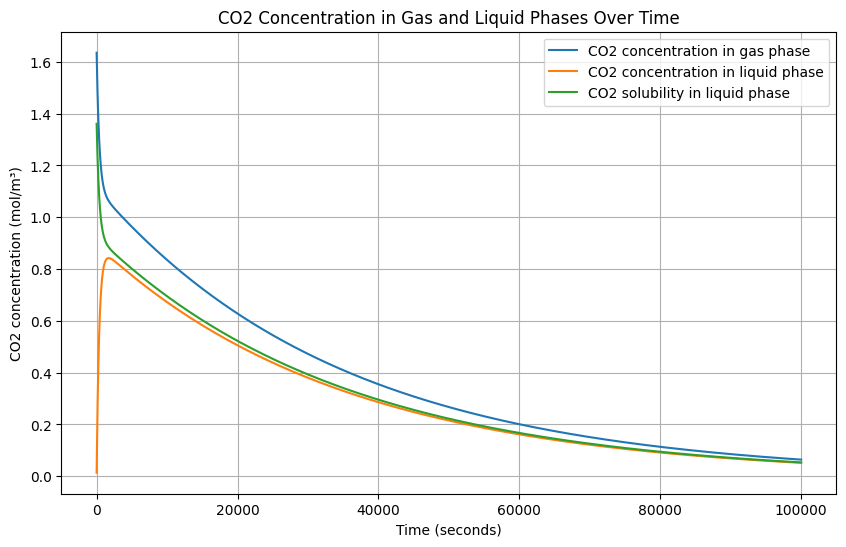

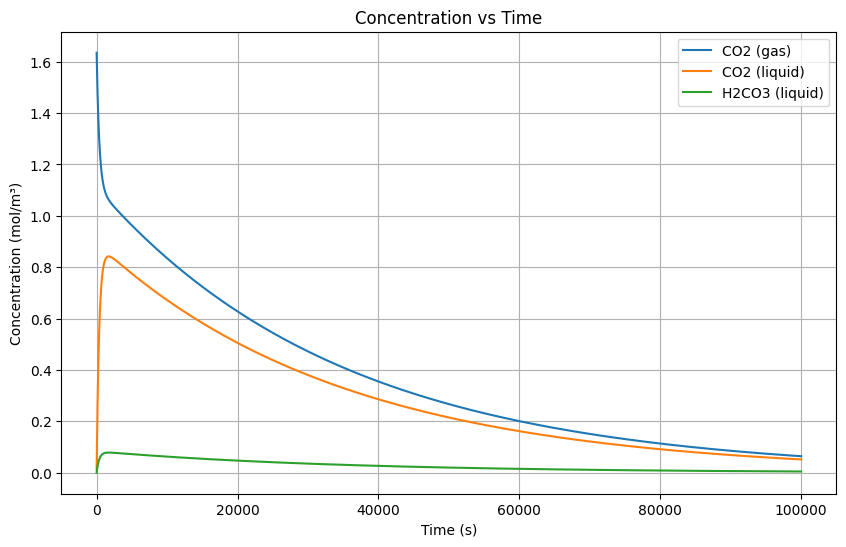

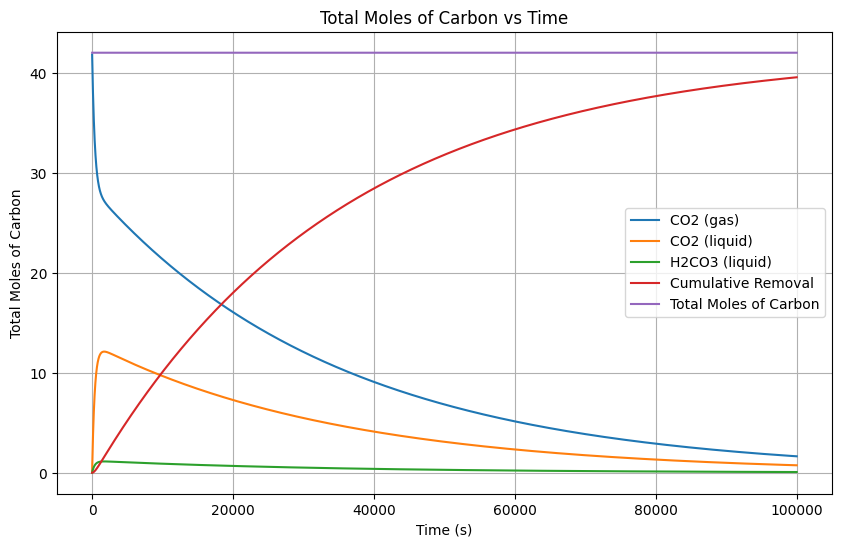

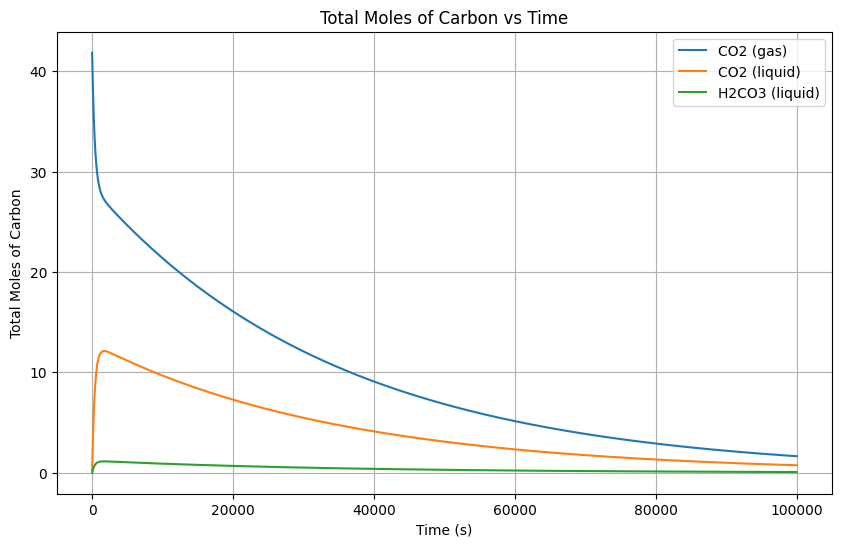

In [6]:
# Print final concentrations and mass transfer rate at the end of the simulation
H2CO3_values.append(H2CO3_new)
final_mass_transfer_rate = k * available_surface_area * (C_g_values[-1] - C_l_values[-1])
print(f"Final concentration of CO2 in the gas phase: {C_g_values[-1]:.6f} mol/m³")
print(f"Final concentration of CO2 in the liquid phase: {C_l_values[-1]:.6f} mol/m³")
print(f"Final mass transfer rate: {final_mass_transfer_rate:.6f} mol/s")
print(f"Final HCO3: {H2CO3_values[-1]:.6f} mol/m³")

# Final total moles of carbon in the system
final_moles_CO2_gas = C_g_values[-1] * gas_volume
final_moles_CO2_liquid = C_l_values[-1] * liquid_volume
final_moles_H2CO3 = H2CO3_values[-1] * liquid_volume
final_total_moles_carbon = final_moles_CO2_gas + final_moles_CO2_liquid + final_moles_H2CO3 + cumulative_removal_values[-1]

# Print initial and final total moles of carbon
print(f"Initial total moles of carbon: {initial_total_moles_carbon:.6f} mol")
print(f"Final total moles of carbon: {final_total_moles_carbon:.6f} mol")

# Print cumulative total moles of carbon removed
print(f"Cumulative total moles of carbon removed: {cumulative_removal_values[-1]:.6f} mol")
print(f"Cumulative total mass of carbon removed: {0.044*cumulative_removal_values[-1]:.6f} kg")


time_points.append(time_points[-1] + time_step)  # Increment time by the time step
C_g_values.append(C_g_new)
C_l_values.append(C_l_new)
C_sol_values.append(C_sol_new)
cumulative_removal_values.append(cumulative_removal_values[-1])
total_moles_carbon_values.append(total_moles_carbon)



# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, C_g_values, label='CO2 concentration in gas phase')
plt.plot(time_points, C_l_values, label='CO2 concentration in liquid phase')
plt.plot(time_points, C_sol_values, label='CO2 solubility in liquid phase')
plt.xlabel('Time (seconds)')
plt.ylabel('CO2 concentration (mol/m³)')
plt.title('CO2 Concentration in Gas and Liquid Phases Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, C_g_values, label="CO2 (gas)")
plt.plot(time_points, C_l_values, label="CO2 (liquid)")
plt.plot(time_points,H2CO3_values, label="H2CO3 (liquid)")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (mol/m³)")
plt.legend()
plt.title("Concentration vs Time")
plt.grid(True)
plt.show()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, [val * gas_volume for val in C_g_values], label="CO2 (gas)")
plt.plot(time_points, [val * liquid_volume for val in C_l_values], label="CO2 (liquid)")
plt.plot(time_points, [val * liquid_volume for val in H2CO3_values], label="H2CO3 (liquid)")
plt.plot(time_points, cumulative_removal_values, label="Cumulative Removal")
plt.plot(time_points, total_moles_carbon_values, label="Total Moles of Carbon")
plt.xlabel("Time (s)")
plt.ylabel("Total Moles of Carbon")
plt.legend()
plt.title("Total Moles of Carbon vs Time")
plt.grid(True)
plt.show()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_points, [val * gas_volume for val in C_g_values], label="CO2 (gas)")
plt.plot(time_points, [val * liquid_volume for val in C_l_values], label="CO2 (liquid)")
plt.plot(time_points, [val * liquid_volume for val in H2CO3_values], label="H2CO3 (liquid)")
plt.xlabel("Time (s)")
plt.ylabel("Total Moles of Carbon")
plt.legend()
plt.title("Total Moles of Carbon vs Time")
plt.grid(True)
plt.show()

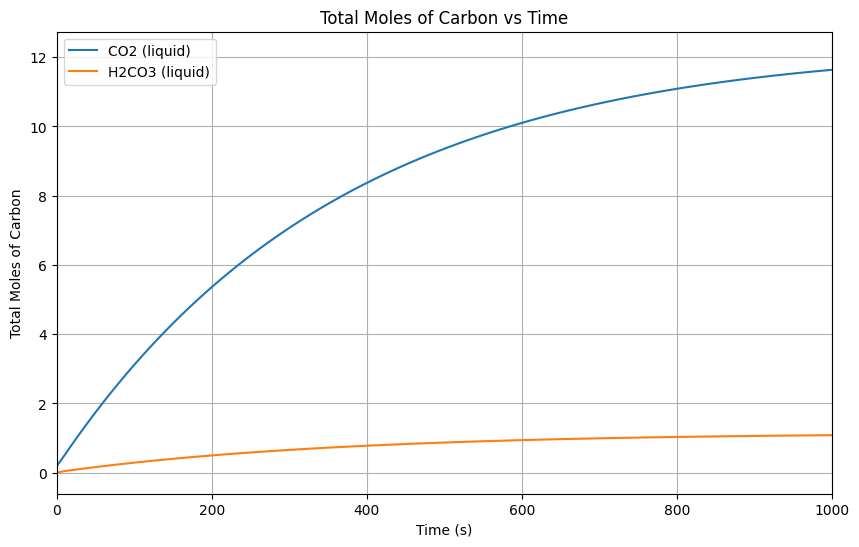

In [14]:
# Plot results
plt.figure(figsize=(10, 6))
#plt.plot(time_points, [val * gas_volume for val in C_g_values], label="CO2 (gas)")
plt.plot(time_points, [val * liquid_volume for val in C_l_values], label="CO2 (liquid)")
plt.plot(time_points, [val * liquid_volume for val in H2CO3_values], label="H2CO3 (liquid)")
plt.xlabel("Time (s)")
plt.ylabel("Total Moles of Carbon")
plt.legend()
plt.title("Total Moles of Carbon vs Time")

# Set x axis
plt.xlim(0, 1e3)
plt.grid(True)

plt.show()